# DenseASPP
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [5]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [6]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [8]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [10]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [11]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [12]:
transforms2=Compose([],p=1)

In [13]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [14]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [15]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [16]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [17]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [18]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

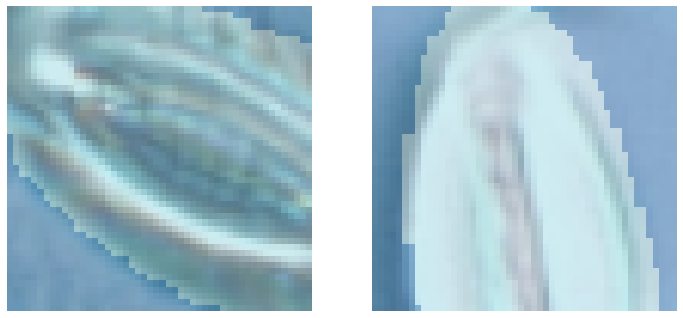

In [19]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [ ]:
from architectures import DenseASPP
model = DenseASPP(backbone_name="resnet101", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [22]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DenseASPP"

Freeze y elección de la tasa de aprendizaje.

Recorder

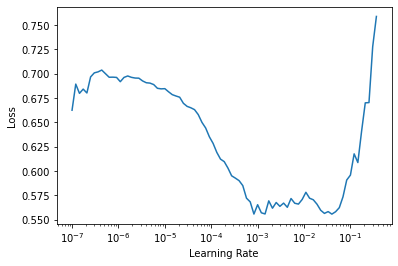

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.243699,91.194145,0.919865,0.851620,11:00
1,0.227517,71.182480,0.925874,0.861980,10:56
2,0.206595,7.902600,0.927917,0.865528,10:49
3,0.194629,23.857487,0.935530,0.878870,10:44
4,0.187894,3.390759,0.937018,0.881500,10:37
5,0.195682,0.275488,0.945870,0.897300,10:47
6,0.192198,0.192365,0.951351,0.907216,10:33
7,0.189486,0.210225,0.948559,0.902151,10:38
8,0.163359,0.184562,0.951925,0.908261,10:38
9,0.189701,0.188059,0.952447,0.909211,10:42


Better model found at epoch 0 with valid_loss value: 91.19414520263672.


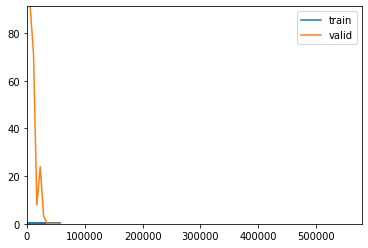

Better model found at epoch 1 with valid_loss value: 71.18247985839844.
Better model found at epoch 2 with valid_loss value: 7.902599811553955.
Better model found at epoch 4 with valid_loss value: 3.390758752822876.
Better model found at epoch 5 with valid_loss value: 0.27548763155937195.
Better model found at epoch 6 with valid_loss value: 0.19236503541469574.
Better model found at epoch 8 with valid_loss value: 0.18456214666366577.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17972981929779053,0.9529072915386154,0.9100505464686439]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

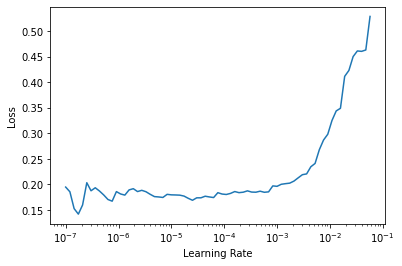

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.180192,0.176800,0.954060,0.912156,11:33
1,0.158461,0.174251,0.955152,0.914154,11:31
2,0.158371,0.186085,0.953601,0.911318,11:30
3,0.179000,0.176719,0.954559,0.913068,11:27


Better model found at epoch 0 with valid_loss value: 0.17679961025714874.


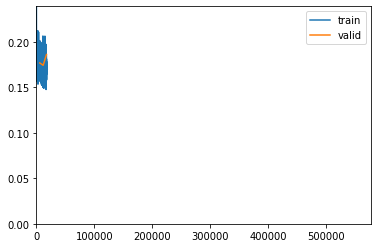

Better model found at epoch 1 with valid_loss value: 0.1742510199546814.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1742510199546814,0.9551518165146985,0.9141536843454111]



---


Definición del modelo.

In [ ]:
del model, learn
model = DenseASPP(backbone_name="resnet101", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DenseASPP"

Freeze y elección de la tasa de aprendizaje.

Recorder

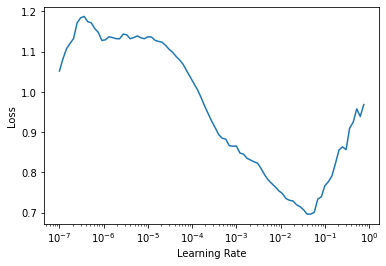

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

Better model found at epoch 1 with valid_loss value: 12.914626121520996.
Better model found at epoch 2 with valid_loss value: 6.229817867279053.


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.236884,68.839935,0.868778,0.768000,10:43
1,0.233445,12.914626,0.921659,0.854701,10:33
2,0.218518,6.229818,0.937262,0.881931,10:36
3,0.201130,1.257757,0.941474,0.889420,10:32
4,0.199905,0.295046,0.943697,0.893397,10:34
5,0.194522,0.217690,0.947356,0.899978,10:42
6,0.189268,0.203313,0.949624,0.904081,10:36
7,0.183130,0.185444,0.952447,0.909212,10:40
8,0.175658,0.196900,0.951293,0.907110,10:54
9,0.182818,0.192893,0.951065,0.906696,10:40


Better model found at epoch 3 with valid_loss value: 1.2577574253082275.


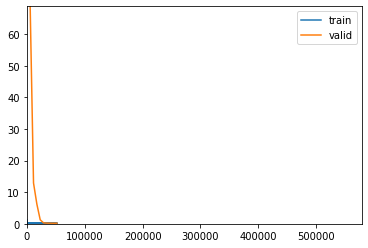

Better model found at epoch 4 with valid_loss value: 0.29504644870758057.
Better model found at epoch 5 with valid_loss value: 0.2176900953054428.
Better model found at epoch 6 with valid_loss value: 0.20331336557865143.
Better model found at epoch 7 with valid_loss value: 0.18544387817382812.
No improvement since epoch 7: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18544387817382812,0.9524473747817117,0.909211959239987]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

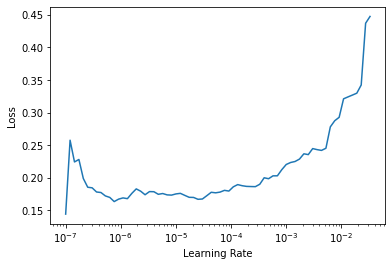

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.177397,0.190217,0.952009,0.908413,10:34
1,0.174985,0.193241,0.952406,0.909136,10:38
2,0.183762,0.184975,0.953190,0.910566,10:36
3,0.182912,0.182775,0.952388,0.909104,10:36
4,0.177787,0.200207,0.950783,0.906183,10:32
5,0.196761,0.179093,0.954038,0.912115,10:31
6,0.181365,0.190403,0.952097,0.908574,10:34
7,0.171276,0.203538,0.951645,0.907751,10:34


Better model found at epoch 0 with valid_loss value: 0.19021742045879364.


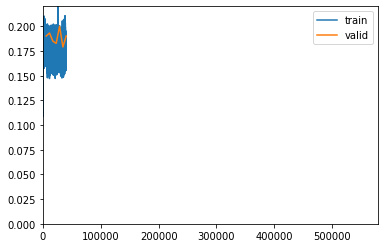

Better model found at epoch 2 with valid_loss value: 0.18497508764266968.
Better model found at epoch 3 with valid_loss value: 0.18277521431446075.
Better model found at epoch 5 with valid_loss value: 0.17909270524978638.
No improvement since epoch 5: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17909270524978638,0.9540376543970002,0.9121147223010166]

# Modelos sin aumento de datos
Definición del modelo.

In [23]:
del model, learn
model = DenseASPP(backbone_name="resnet101", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [24]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DenseASPP"

Freeze y elección de la tasa de aprendizaje.

Recorder

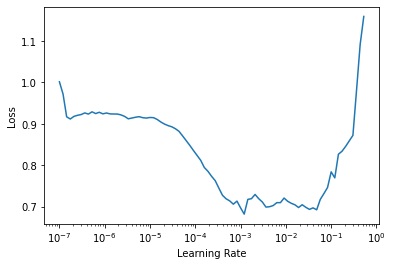

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.269713,141.349823,0.886544,0.796210,10:49
1,0.228461,12.535750,0.930695,0.870374,11:00
2,0.231893,14.871781,0.932491,0.873521,10:54
3,0.214924,0.668366,0.942400,0.891075,10:49
4,0.203589,0.290500,0.946773,0.898926,10:56
5,0.189377,0.198824,0.949972,0.904712,10:45
6,0.194957,0.182084,0.953246,0.910669,10:39
7,0.190895,0.184992,0.952381,0.909091,10:44
8,0.175904,0.177880,0.954380,0.912741,10:47
9,0.185633,0.185757,0.953290,0.910748,10:52


Better model found at epoch 0 with valid_loss value: 141.34982299804688.


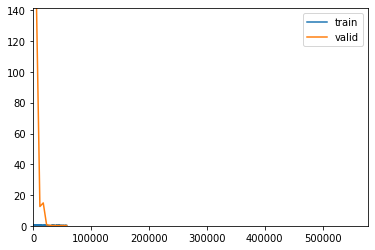

Better model found at epoch 1 with valid_loss value: 12.535750389099121.
Better model found at epoch 3 with valid_loss value: 0.6683663725852966.
Better model found at epoch 4 with valid_loss value: 0.29050034284591675.
Better model found at epoch 5 with valid_loss value: 0.19882403314113617.
Better model found at epoch 6 with valid_loss value: 0.18208429217338562.
Better model found at epoch 8 with valid_loss value: 0.1778804361820221.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1778804361820221,0.9543802390734919,0.9127412035784689]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

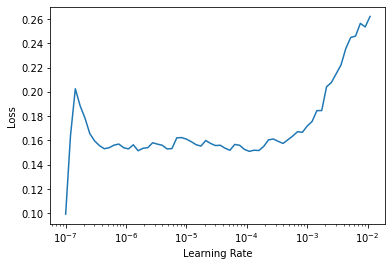

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.173011,0.165175,0.957573,0.918600,10:56
1,0.165619,0.168516,0.956817,0.917210,10:58
2,0.172145,0.168941,0.956650,0.916902,10:46


Better model found at epoch 0 with valid_loss value: 0.16517525911331177.


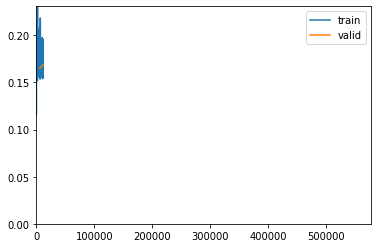

No improvement since epoch 0: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16517525911331177,0.9575731271751398,0.9185998098650544]



---


Definición del modelo.

In [ ]:
del model, learn
model = DenseASPP(backbone_name="resnet101", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/DenseASPP"

Freeze y elección de la tasa de aprendizaje.

Recorder

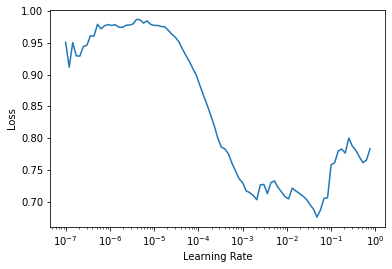

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.238092,19.574673,0.905135,0.826710,10:54
1,0.237484,123.625549,0.857332,0.750289,11:04
2,0.212822,3.503086,0.928388,0.866347,11:13
3,0.196145,3.692112,0.937863,0.882996,11:02
4,0.196561,4.947459,0.941553,0.889561,10:52


Better model found at epoch 0 with valid_loss value: 19.57467269897461.


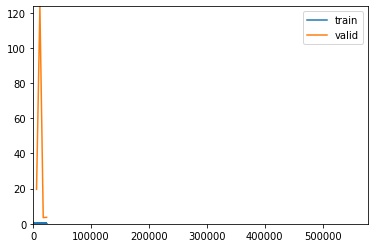

Better model found at epoch 2 with valid_loss value: 3.5030860900878906.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [3.5030860900878906,0.9283881545593469,0.8663474172195139]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

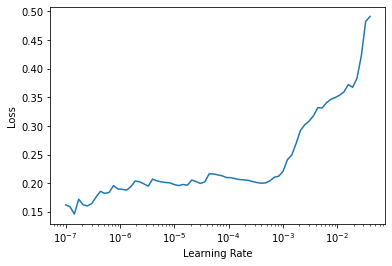

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.210595,10.215701,0.931142,0.871156,10:46
1,0.202300,4.595582,0.935507,0.878829,10:45
2,0.186691,2.006356,0.941481,0.889432,10:47
3,0.188197,0.659953,0.944556,0.894937,10:52
4,0.194824,0.257227,0.948602,0.902230,11:01
5,0.187302,0.200713,0.949334,0.903555,10:52
6,0.181856,0.188398,0.951806,0.908043,10:50
7,0.178252,0.178505,0.954200,0.912412,10:51
8,0.169862,0.178391,0.953719,0.911533,10:53
9,0.174478,0.174437,0.954180,0.912375,10:51


Better model found at epoch 0 with valid_loss value: 10.21570110321045.


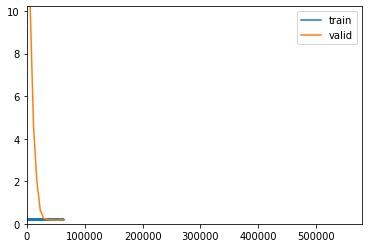

Better model found at epoch 1 with valid_loss value: 4.595582485198975.
Better model found at epoch 2 with valid_loss value: 2.0063564777374268.
Better model found at epoch 3 with valid_loss value: 0.659953236579895.
Better model found at epoch 4 with valid_loss value: 0.2572273313999176.
Better model found at epoch 5 with valid_loss value: 0.20071280002593994.
Better model found at epoch 6 with valid_loss value: 0.18839792907238007.
Better model found at epoch 7 with valid_loss value: 0.17850537598133087.
Better model found at epoch 8 with valid_loss value: 0.17839109897613525.
Better model found at epoch 9 with valid_loss value: 0.17443713545799255.
No improvement since epoch 9: early stopping


In [ ]:
name = "model_DenseASPP_resnet101_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17443713545799255,0.9541800484838361,0.9123750671427964]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16561827063560486,0.9571105340181364,0.9177487789820872]

Comparación de resultado buscado contra resultado obtenido.

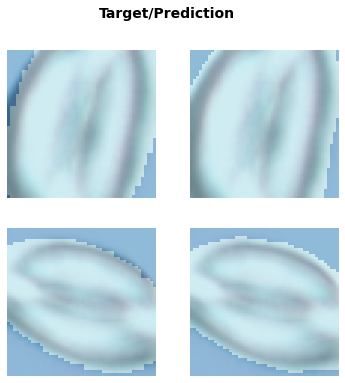

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16122087836265564,0.9585358568157096,0.9203733638730698]

Comparación de resultado buscado contra resultado obtenido.

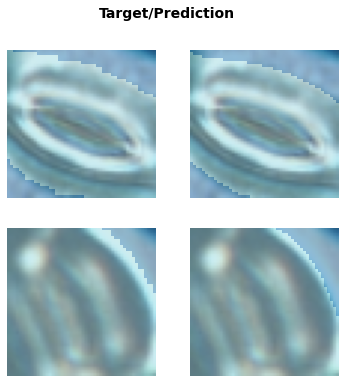

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16735047101974487,0.9566920583850725,0.9169795610912508]

Comparación de resultado buscado contra resultado obtenido.

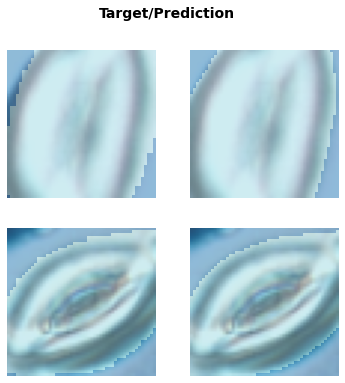

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16318757832050323,0.9581545460739319,0.9196705158747325]

Comparación de resultado buscado contra resultado obtenido.

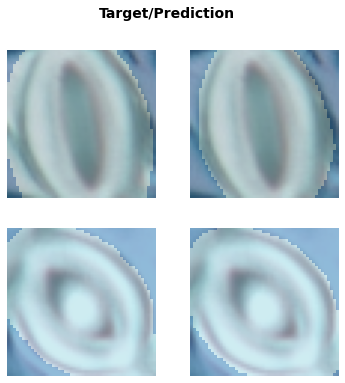

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16231891512870789,0.9584104701364528,0.9201421890848006]

Comparación de resultado buscado contra resultado obtenido.

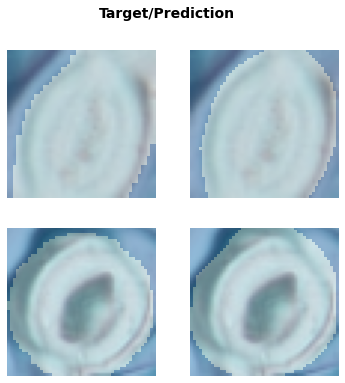

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16021078824996948,0.9591173850888933,0.9214462527753947]

Comparación de resultado buscado contra resultado obtenido.

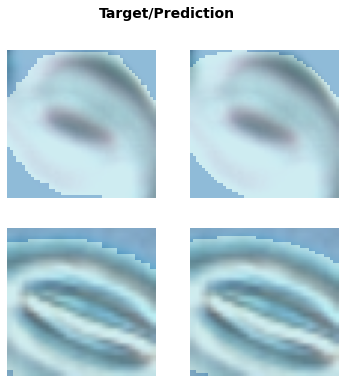

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [2.103245258331299,0.9353771425260172,0.8785995303025663]

Comparación de resultado buscado contra resultado obtenido.

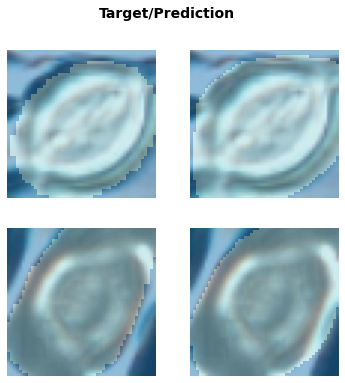

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_DenseASPP_resnet101_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.164717435836792,0.9571009718194006,0.9177311954054855]

Comparación de resultado buscado contra resultado obtenido.

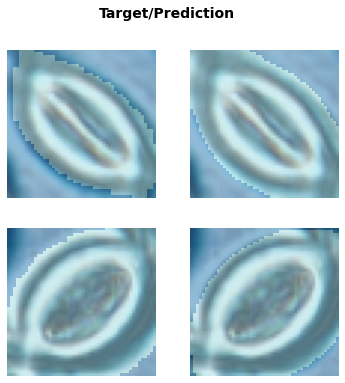

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [25]:
learn.load("model_DenseASPP_resnet101_wd2_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16021090745925903,0.9591173850888933,0.9214462527753947]

In [26]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [27]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/DenseASPP/model_DenseASPP_resnet101.pkl")